# Segmentación Semántica Multiclase Usando la Base de Datos WeedMap
---

## Ficha Técnica
 - **Autor:** Victor Arias
 - **Fecha:** 14/04/2022
 - **Problematica:** En este notebook se busca entrenar una arquitectura de red neuronal de dos etapas con imágenes multiespectrales obtenidas por el sensor **RedEdge-M** de MicaSense. Además, se busca implementar una estrategia de entrenamiento distribuido aprovechando el acceso a TPUs por parte de la herramienta Colab, acelerando la búsqueda de hiperparámetros.

 - **Hipotesis:** Es posible entrenar un modelo de segmentacion multiclase para construir un mapa de maleza a partir de un mapa ortomosaico multiespectral, este modelo estara basado en la arquitectura de la [DriuNet](https://arxiv.org/abs/1609.01103).
 - **Metodología:** La metodología aplicada en esta experimentación consiste en usar una arquitectura de dos etapas, la primera etapa consiste de un autoencoder que hace las veces de reductor de dimensionalidad teniendo como entrada/salida una imagen multiespectral. La salida, que sirve como entrada a la siguiente etapa, es una capa convolucional intermedia de tres (canales) que comprime la representación multiespectral. La siguiente etapa es la arquitectura DriuNet, esta arquitectura recibe una imagen RGB de entrada (nuestra representación de tres canales es un equivalente válido) y genera un mapa ortomosaico cuyos píxeles puede contener cada una las tres clases a inferir (maleza, cultivo y fondo).

 - **Recursos adiciones:**
     - **Entradas:**
         - **Entrada 1:** Base de datos [WeedMap](https://projects.asl.ethz.ch/datasets/doku.php?id=weedmap:remotesensing2018weedmap) con imágenes multiespectrales en formato TFRecord.
     - **Salidas:**
         - **Salida 1:** Modelos entrenados con un conjunto de hiperparámetros que incluyen taza de aprendizaje y tamaño de lote *Almacenado en Drive*.
         - **Salida 2:** Modelo con los hiperparámetros que generan los mejores resultados *Almacenado en Drive*.
 - **Para replicar el experimento:**
    1. Tener acceso a una Google Cloud Storage.
    2. Almacenar la base de datos en formato TFRecord en un storage (los pasos para crear la base de datos en este formato se encuentran en el siguiente [repositorio](https://github.com/viariasv/segsem-tfrecord)).
    3. Ejecute el notebook.

    **Nota**: El **Paso 5** del notebook tiene código comentado cuyo fin es traslador datos almacenados en Drive a GCS.

 - **Resumen:**
Se estrenó un modelo de ResNet-50 para clasificar el tag de fondo de una imagen de portada de un ítem. Los resultados son prometedores, aunque se debe buscar la manera de mejorar la tesas de falsos negativos. El modelo entrenado, la base de datos y la gráfica de perdidas generadas son las salidas del notebook.


## Paso 1: Descargar e instalar las librerías necesarias (no incluidas en Colab)

In [ ]:
!pip install keras_tuner
!pip install -U segmentation-models
!pip install clearml
!echo “deb http://packages.cloud.google.com/apt gcsfuse-bionic main” > /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
!apt -qq update
!apt -qq install gcsfuse

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2537  100  2537    0     0   130k      0 --:--:-- --:--:-- --:--:--  130k
OK
E: Type '“deb' is not known on line 1 in source list /etc/apt/sources.list.d/gcsfuse.list
E: The list of sources could not be read.
E: Type '“deb' is not known on line 1 in source list /etc/apt/sources.list.d/gcsfuse.list
E: The list of sources could not be read.
E: Type '“deb' is not known on line 1 in source list /etc/apt/sources.list.d/gcsfuse.list
E: The list of sources could not be read.


### Paso 2: Importar las librerías necesarias

In [ ]:
# Load the TensorBoard notebook extension
%matplotlib inline
%load_ext tensorboard

import os
import re
import cv2
import sys
import json
import h5py
import random
import pathlib
import operator
import datetime
import numpy as np
import pandas as pd
from PIL import Image
from time import time
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from IPython.display import clear_output
from collections import defaultdict, OrderedDict
from sklearn.metrics import roc_auc_score, accuracy_score

# Tensorflow libraries
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import *
from tensorboard.plugins.hparams import api as hp
from tensorflow.keras.layers.experimental import preprocessing 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Add, Dropout, Permute, add
from tensorflow.keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D, Cropping2D, Conv2D, UpSampling2D
from tensorflow.python.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from clearml import Task
from clearml.external.kerastuner import ClearmlTunerLogger


import keras_tuner as kt
import segmentation_models as sm
sm.set_framework('tf.keras')

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Step 3: Configurar y detectar el hardware de entrenamiento (TPU v2)

In [ ]:
try:
  tpu_resolver = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
  tpu_resolver = None
  gpus = tf.config.experimental.list_logical_devices("GPU")

# Select appropriate distribution strategy
if tpu_resolver:
  tf.config.experimental_connect_to_cluster(tpu_resolver)
  tf.tpu.experimental.initialize_tpu_system(tpu_resolver)
  strategy = tf.distribute.experimental.TPUStrategy(tpu_resolver)
  print('Running on TPU ', tpu_resolver.cluster_spec().as_dict()['worker'])

elif len(gpus) > 1:
  strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
  print('Running on multiple GPUs ', [gpu.name for gpu in gpus])

elif len(gpus) == 1:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on single GPU ', gpus[0].name)

else:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU
  print('Running on CPU')
  
print("Number of accelerators: ", strategy.num_replicas_in_sync)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.87.43.130:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.87.43.130:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Running on TPU  ['10.87.43.130:8470']
Number of accelerators:  8


### Paso 4: Definir las variables de configuración

In [ ]:
SELECTED_NUM = "7"
CHANNELS = 5

CONFIG = {
    # define the path to our output directory
    "OUTPUT_PATH": f"/output/HP_SEARCH_{CHANNELS}CH_32BS_CUSTOM",
    "PLOTTING_PATH": f"/output/HP_SEARCH_{CHANNELS}CH_32BS_CUSTOM/images",

    # initialize the input shape and number of classes
    "INPUT_SHAPE": (224, 224, CHANNELS),
    "OUTPUT_SHAPE": [224, 224, 3],
    "NUM_CLASSES": 3,

    "TRAIN_LENGTH": 3060,
    "VAL_LENGTH": 770,
    "HYPERP_TUNNING_TECH": "random",

    # define the total number of epochs to train, batch size, buffer size and the
    # early stopping patience
    "BS": 4,
    "EPOCHS_SEARCH": 200,
    "EPOCHS_TRAINING": 500,
    "VAL_SIZE": 0.2,
    "BUFFER_SIZE": 1000,
    "EARLY_STOPPING_PATIENCE_SEARCH":10,
    "EARLY_STOPPING_PATIENCE_TRAINING": 20,

    # configuration dataset
    "DATA": {
        "PATTERNS": {
            "1": ["B", "CIR", "G", "NDVI", "NIR", "R", "RE", "RGB"],
            "2": ["B", "CIR", "G", "NIR", "R", "RE", "RGB"],
            "3": ["B", "CIR", "G", "NDVI", "NIR", "R", "RE"],
            "4": ["B", "NDVI", "G", "NIR", "R", "RE", "RGB"],
            "5": ["B", "NIR", "G", "R", "RE", "RGB"],
            "6": ["NIR", "R", "G", "RGB"],
            "7": ["RGB" "NIR", "RE"],
            "8": ["RGB"],
            "9": ["B", "G", "R"],
            "10": ["NDVI"],
            "11": ["NIR"]
        },
        "CHANNELS": {
            "1" : 12,
            "2" : 11,
            "3" : 9,
            "4" : 9,
            "5" : 8,
            "6" : 6,
            "7" : 5,
            "8" : 3,
            "9" : 3,
            "10" : 1,
            "11" : 1
        },
    }
}


## Paso 5: Cargar el bucket con la base de datos en GCS

In [ ]:
from google.colab import auth
auth.authenticate_user()
project_id = 'datasetthesisweedmap'


# Descomentar cuando se requiera transladar datos creados en gdrive a GCS
from google.colab import drive
drive.mount('/gdrive')

Updated property [core/project].
Mounted at /gdrive


In [ ]:
############### translate data into a GCP bucket #########
project_id = 'datasetThesisWeedmap'
!gcloud config set project {project_id}
!gsutil ls
BUCKET_NAME = 'gs://dataset_thesis_weedmap'

# translate the drive data to google storage
!gsutil -m cp -r /gdrive/MyDrive/masther_thesis_experiments/dataset/tfrecord/WEEDMAP_5CH/* gs://{bucket_name}/tfrecord/WEEDMAP_5CH

Are you sure you wish to set property [core/project] to deep-weed-research?

Do you want to continue (Y/n)?  y

Updated property [core/project].
You are attempting to access protected data with no configured
credentials. Please visit https://cloud.google.com/console#/project
and sign up for an account, and then run the "gcloud auth login"
command to configure gsutil to use these credentials.


## Paso 6: Definir configuraciones adicionales

Se define la base de datos con la que se va a entrenar el modelo:

1. El número de canales de la imagen de entrada
2. El diccionario que convierte el ID de la clase de salida en su
valor de pixel
3. Las rutas de las diferentes secciones de la base de datos(train, val y test)

In [ ]:
DATASET_NAME = "WEEDMAP_5CH"

PATTERN = CONFIG["DATA"]["PATTERNS"][SELECTED_NUM]
NUM_INPUT_CHANNELS = CONFIG["DATA"]["CHANNELS"][SELECTED_NUM]
id2code = {0: (0, 0, 0), 1: (255, 0, 0), 2: (0, 255, 0)}

# path to the bucket splits
FILENAME_PATTERN_TRAIN = str(BUCKET_NAME + f"/tfrecord/{DATASET_NAME}/train/*.record")
FILENAME_PATTERN_VAL = str(BUCKET_NAME + f"/tfrecord/{DATASET_NAME}/val/*.record")
FILENAME_PATTERN_TEST =  str(BUCKET_NAME + f"/tfrecord/{DATASET_NAME}/test/*.record")

## Paso 7: Cargando los objetos para los datos en formato TFRecord 


In [ ]:
def normalize(input_image: tf.Tensor, input_mask: tf.Tensor) -> tuple:
    """Rescale the pixel values of the images between 0.0 and 1.0
    compared to [0,255] originally.

    Parameters
    ----------
    input_image : tf.Tensor
        Tensorflow tensor containing an image of size [SIZE,SIZE,3].
    input_mask : tf.Tensor
        Tensorflow tensor containing an annotation of size [SIZE,SIZE,1].

    Returns
    -------
    tuple
        Normalized image and its annotation.
    """
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_image.set_shape([224, 224, NUM_INPUT_CHANNELS])
    input_mask.set_shape([224, 224, 3])
    return input_image, input_mask

def rgb_to_semantic_map(mask):
    """convert a RGB image to one hot encoder channels

    Parameters
    ----------
    mask : RGB mask image

    Returns
    -------
    tf.Tensor
        semantic map with a class by channel
    """

    palette = np.array(
    [[0,  0, 0],
    [255,  0, 0],
    [ 0,  255,  0]], np.uint8)

   
    class_1_map = tf.reduce_all(tf.equal(mask, palette[0]), axis=-1)
    class_2_map = tf.reduce_all(tf.equal(mask, palette[1]), axis=-1)
    class_3_map = tf.reduce_all(tf.equal(mask, palette[2]), axis=-1)
    semantic_map = tf.stack([class_1_map, class_2_map, class_3_map], axis=-1)

    # NOTE cast to tf.float32 because most neural networks operate in float32.
    semantic_map = tf.cast(semantic_map, tf.float32)

    return semantic_map

def rgb_to_onehot(mask, colormap=id2code):
    '''Function to one hot encode RGB mask labels
    
    Parameters
    ----------
        mask: image matrix (eg. 256 x 256 x 3 dimension numpy ndarray)
        colormap: dictionary of color to label id
    
    Returns
    -------
    tf.Tensor
        One hot encoded image of dimensions (height x width x num_classes) where num_classes = len(colormap)
    '''
    shape = mask.get_shape()
    encoded_image = tf.zeros_like(mask)
    list_masks = []

    for i, cls in enumerate(colormap):
        list_masks.append(tf.reshape(tf.reduce_all(tf.equal(tf.reshape(mask,[-1, 3]) , colormap[i]), axis=1), [224, 224]))
    
    encoded_image = tf.stack(list_masks, axis=-1)
    encoded_image = tf.cast(encoded_image, tf.float32)

    return encoded_image

def semantic_map_to_rgb(sm):
    """convert one hot enconder channels to RGB Image
    

    Parameters
    ----------
        sm: semantic map with a class by channel
    
    Returns
    -------
    tf.Tensor
        RGB mask image
    '''
    """
    palette = np.array(
    [[0,  0, 0],
    [255,  0, 0],
    [ 0,  255,  0]], np.uint8)

    palette = tf.constant(palette, dtype=tf.uint8)
    class_indexes = tf.argmax(sm, axis=-1)
    # NOTE this operation flattens class_indexes
    class_indexes = tf.reshape(class_indexes, [-1])
    color_image = tf.gather(palette, class_indexes)
    color_image = tf.reshape(color_image, CONFIG["OUTPUT_SHAPE"])

    return color_image

def onehot_to_rgb(onehot, colormap=id2code):
    '''Function to decode encoded mask labels
        Inputs: 
            onehot - one hot encoded image matrix (height x width x num_classes)
            colormap - dictionary of color to label id
        Output: Decoded RGB image (height x width x 3) 
    '''
    single_layer = tf.argmax(onehot, axis=-1)
    #shape = onehot.get_shape()
    output = np.zeros([224, 224, 3])

    for k in colormap.keys():
        output[single_layer==k] = colormap[k]
    return tf.cast(output, tf.uint8)

def read_tfrecord(data):
    """Read the tf.data object and return both images and mask for a single
    example.
    """
    image_feature_description = {
        'image/input': tf.io.FixedLenFeature([], tf.string),
        'image/height': tf.io.FixedLenFeature([], tf.int64),
        'image/width': tf.io.FixedLenFeature([], tf.int64),
        'image/channels': tf.io.FixedLenFeature([], tf.int64),
        'mask/output': tf.io.FixedLenFeature([], tf.string),
        'mask/channels': tf.io.FixedLenFeature([], tf.int64)
    }

    tf_record = tf.io.parse_single_example(data, image_feature_description)

    image_raw = tf_record['image/input']
    mask_raw = tf_record['mask/output']
    
    # images transformation
    image = tf.io.parse_tensor(image_raw, out_type=tf.uint8)
    mask = tf.io.parse_tensor(mask_raw, out_type=tf.uint8)

    image, mask = normalize(image, mask)
    mask = rgb_to_onehot(mask)

    return image, (image, mask)

AUTO = tf.data.experimental.AUTOTUNE
ignore_order = tf.data.Options()
ignore_order.experimental_deterministic = False

train_filenames = tf.io.gfile.glob(FILENAME_PATTERN_TRAIN)
val_filenames = tf.io.gfile.glob(FILENAME_PATTERN_VAL)
test_filenames = tf.io.gfile.glob(FILENAME_PATTERN_TEST)

train_data_raw = tf.data.TFRecordDataset(train_filenames, num_parallel_reads=AUTO)
val_data_raw = tf.data.TFRecordDataset(val_filenames, num_parallel_reads=AUTO)
test_data_raw = tf.data.TFRecordDataset(test_filenames, num_parallel_reads=AUTO)

# decoding a tf.data.TFRecordDataset
train_data = train_data_raw.map(read_tfrecord)
val_data = val_data_raw.map(read_tfrecord)
test_data = test_data_raw.map(read_tfrecord)

## Paso 8: Preprocesando los datos 

**Nota:** No se hará nada importante en términos de preprocesamiento en la búsqueda de hiperparámetros.

In [ ]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same randomn changes.
    self.augment_inputs = preprocessing.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = preprocessing.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image with 5CH', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(display_list[i])
        plt.axis('off')
    plt.show()

train_batches = (
    train_data
    .cache()
    .shuffle(CONFIG["BUFFER_SIZE"])
    .batch(CONFIG["BATCH_SIZE"] * strategy.num_replicas_in_sync)
    .repeat()
    .prefetch(buffer_size=tf.data.AUTOTUNE))

val_batches = (
    val_data
    .cache()
    .shuffle(CONFIG["BUFFER_SIZE"])
    .batch(CONFIG["BATCH_SIZE"] * strategy.num_replicas_in_sync)
    .repeat()
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_data.batch(CONFIG["BATCH_SIZE"])

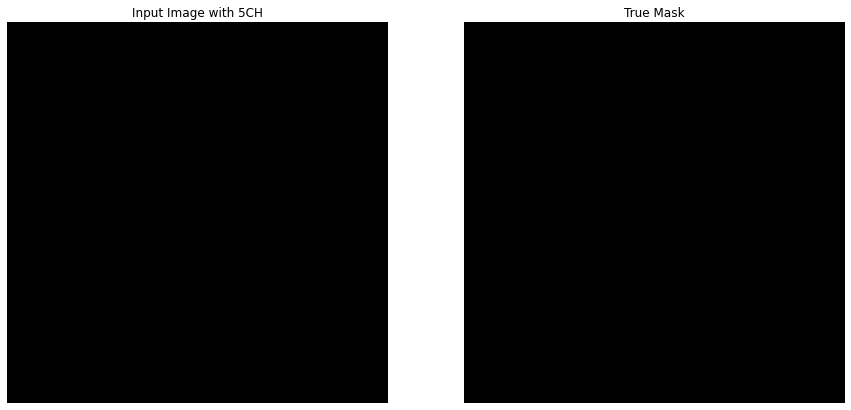

In [ ]:
for images, (images2, masks) in train_batches.take(1):
  sample_image, sample_mask = images2[0][:,:,:3], onehot_to_rgb(masks[0])
  display([sample_image, sample_mask])

# Arquitectura

In [ ]:
# metrics definition
smooth = 1.0
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f*y_true_f) + K.sum(y_pred_f*y_pred_f) + smooth)

def autoencoder():
    x = Input(shape=(CONFIG['INPUT_SHAPE'][0], CONFIG['INPUT_SHAPE'][1], CONFIG['INPUT_SHAPE'][2])) 

    # Encoder
    conv1_1 = Conv2D(3, (3, 3), activation='relu', padding='same', name='fe_layer1')(x)
    pool1 = MaxPooling2D((2, 2), padding='same')(conv1_1)
    x1 = Conv2D(16, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D((2, 2), padding='same')(x1)
    conv1_3 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool2)
    h = MaxPooling2D((2, 2), padding='same')(conv1_3)
    conv1_4 = Conv2D(64, (1, 1), activation='relu', padding='same')(h)

    # Decoder
    conv2_1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1_4)
    up1 = UpSampling2D((2, 2))(conv2_1)
    conv2_2 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1)
    up2 = UpSampling2D((2, 2))(conv2_2)
    conv2_3 = Conv2D(16, (3, 3), activation='relu', padding='same')(up2)
    up3 = UpSampling2D((2, 2))(conv2_3)
    x2 = Conv2D(3, (1, 1), activation='relu', padding='same', name='fe_layer2')(up3)
    r = Conv2D(NUM_INPUT_CHANNELS, (3, 3), activation='relu', padding='same')(x2)

    autoencoder = Model(inputs=x, outputs=r, name="autoencoder")
    base_output_int = autoencoder.get_layer(index = -2).output
    return autoencoder

def build_model(hp=None):

    auto_model = autoencoder()
    base_input = auto_model.input
    base_output = auto_model.output
    AE_O_DRIU_I = auto_model.get_layer(index = -2).output

    # initialize the model along with the input shape and channel dimension
    #inputs = tf.keras.Input(shape=(CONFIG['INPUT_SHAPE'][0], CONFIG['INPUT_SHAPE'][1], CONFIG['INPUT_SHAPE'][2]))

    # first CONV => RELU => CONV => RELU => POOL layer set
    conv1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding="same")(AE_O_DRIU_I)
    conv2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding="same")(conv1)
    pool1 = tf.keras.layers.MaxPool2D((2,2), strides=(2,2))(conv2)

    # second CONV => RELU => CONV => RELU => POOL layer set
    conv3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding="same")(pool1)
    conv4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding="same")(conv3)
    pool2 = tf.keras.layers.MaxPool2D((2,2), strides=(2,2))(conv4)

    # third CONV => RELU => CONV => RELU => CONV => RELU => POOL layer set
    conv5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding="same")(pool2)
    conv6 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding="same")(conv5)
    conv7 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding="same")(conv6)
    pool3 = tf.keras.layers.MaxPool2D((2,2), strides=(2,2))(conv7)

    # fourth CONV => RELU => CONV => RELU => CONV => RELU => POOL layer set
    conv8 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding="same")(pool3)
    conv9 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding="same")(conv8)
    conv10 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding="same")(conv9)
    pool4 = tf.keras.layers.MaxPool2D((2,2), strides=(2,2))(conv10)

    # fifth CONV => RELU => CONV => RELU => CONV => RELU => POOL layer set
    conv11 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding="same")(pool4)
    conv12 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding="same")(conv11)
    conv13 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding="same")(conv12)
    pool5 = tf.keras.layers.MaxPool2D((2,2), strides=(2,2))(conv13)

    # Define the VGG16 feature extractor
    baseline = tf.keras.Model(inputs=base_input, outputs=pool5)

    # Specialized Layers (CONV => RELU => UPSAMPLING)
    conv1_2_16 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding="same")(conv2)
    conv2_2_16 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding="same")(conv4)
    conv3_3_16 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding="same")(conv7)
    conv4_3_16 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding="same")(conv10)
    conv5_3_16 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding="same")(conv13)

    upsample2 = tf.keras.layers.UpSampling2D(size=(2, 2))(conv2_2_16)
    upsample3 = tf.keras.layers.UpSampling2D(size=(4, 4))(conv3_3_16)
    upsample4 = tf.keras.layers.UpSampling2D(size=(8, 8))(conv4_3_16)
    upsample5 = tf.keras.layers.UpSampling2D(size=(16, 16))(conv5_3_16)


    def f(layers):
        return tf.keras.backend.concatenate(layers, axis=-1)

    def f_output_shape(input_shape):
        input_shape = list(input_shape[0])
        input_shape[1] *= 4
        return tuple(input_shape)

    x2 = tf.keras.layers.Lambda(f,f_output_shape)
    x_stack = x2([upsample2, upsample3, upsample4, upsample5])
    final_conv1_sub = tf.keras.layers.Conv2D(CONFIG['NUM_CLASSES'], (3, 3), activation='relu', padding="same")(x_stack)
    final_conv1 = tf.keras.layers.Conv2D(CONFIG['NUM_CLASSES'], (1, 1), activation="softmax")(final_conv1_sub)
    
    # defome the model
    model = tf.keras.Model(inputs=base_input, outputs=[base_output,final_conv1])
    
    # initialize the learning rate choices and optimizer
    if hp:
        lr = hp.Choice("learning_rate", values=np.logspace(np.log10(0.00005), np.log10(0.03), base = 25, num = 20).tolist())
        opt = Adam(learning_rate=lr)
    else:
	    opt = Adam(learning_rate=1e-5)
	# compile the model
    # model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=[dice_coef, sm.metrics.iou_score, sm.metrics.f1_score])
    model.compile(optimizer=opt,loss=['mean_squared_error',"categorical_crossentropy"], metrics=[dice_coef, sm.metrics.iou_score, sm.metrics.f1_score])
    # return the model
    return model

# losss/metric plot function
def save_plot(H, path):
	# plot the training loss and accuracy
	plt.style.use("ggplot")
	plt.figure()
	plt.plot(H.history["loss"], label="train_loss")
	plt.plot(H.history["val_loss"], label="val_loss")
	plt.plot(H.history["accuracy"], label="train_acc")
	plt.plot(H.history["val_accuracy"], label="val_acc")
	plt.title("Training Loss and Accuracy")
	plt.xlabel("Epoch #")
	plt.ylabel("Loss/Accuracy")
	plt.legend()
	plt.savefig(path)
 
# show predictions function
def show_predictions(dataset=None, num=1):
    """Show a sample prediction.

    Parameters
    ----------
    dataset : [type], optional
        [Input dataset, by default None
    num : int, optional
        Number of sample to show, by default 1
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display_sample([image[0], true_mask, create_mask(pred_mask)])
    else:
        # The model is expecting a tensor of the size
        # [BATCH_SIZE, IMG_SIZE, IMG_SIZE, 3]
        # but sample_image[0] is [IMG_SIZE, IMG_SIZE, 3]
        # and we want only 1 inference to be faster
        # so we add an additional dimension [1, IMG_SIZE, IMG_SIZE, 3]
        one_img_batch = sample_image[0][tf.newaxis, ...]
        # one_img_batch -> [1, IMG_SIZE, IMG_SIZE, 3]
        inference = model.predict(one_img_batch)
        # inference -> [1, IMG_SIZE, IMG_SIZE, N_CLASS]
        pred_mask = create_mask(inference)
        # pred_mask -> [1, IMG_SIZE, IMG_SIZE, 1]
        display_sample([sample_image[0], sample_mask[0],
                        pred_mask[0]])

# initialize an early stopping callback to prevent the model from
# overfitting/spending too much time training with minimal gains
es = EarlyStopping(
	monitor="val_loss",
	patience=CONFIG["EARLY_STOPPING_PATIENCE_SEARCH"],
	restore_best_weights=True)

STEPS_PER_EPOCH = CONFIG["TRAIN_LENGTH"] // (CONFIG["BATCH_SIZE"] * strategy.num_replicas_in_sync)
STEPS_PER_EPOCH_VAL = CONFIG["VAL_LENGTH"] // (CONFIG["BATCH_SIZE"] * strategy.num_replicas_in_sync)

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(logdir, histogram_freq=1)

build_model().summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 5  0           []                               
                                )]                                                                
                                                                                                  
 fe_layer1 (Conv2D)             (None, 224, 224, 3)  138         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 112, 112, 3)  0           ['fe_layer1[0][0]']              
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 16  448         ['max_pooling2d[0][0]']    

In [ ]:
autoencoder().summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 5)]     0         
                                                                 
 fe_layer1 (Conv2D)          (None, 224, 224, 3)       138       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 112, 112, 3)      0         
 2D)                                                             
                                                                 
 conv2d_27 (Conv2D)          (None, 112, 112, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 56, 56, 16)       0         
 2D)                                                             
                                                                 
 conv2d_28 (Conv2D)          (None, 56, 56, 32)        

## Paso 10: Ejecutar una búsqueda de hiperparámetros **random**.

In [ ]:
tf.keras.backend.clear_session()

print("[INFO] instantiating a random search tuner object...")
tuner = kt.RandomSearch(
    build_model,
    objective=kt.Objective("val_loss", direction="min"),
    max_trials=20,
    seed=42,
    directory=BUCKET_NAME + CONFIG["OUTPUT_PATH"],
    project_name=CONFIG['HYPERP_TUNNING_TECH'] + f"_WEEDMAP_{NUM_INPUT_CHANNELS}CH",
    distribution_strategy=strategy,)

# perform the hyperparameter search
print("[INFO] performing hyperparameter search...")
tuner.search(
    train_batches,
    steps_per_epoch=STEPS_PER_EPOCH * 3,
    validation_data=val_batches,
    validation_steps=STEPS_PER_EPOCH_VAL,
    epochs = CONFIG["EPOCHS_SEARCH"],
    callbacks=[es]
)

print("[INFO] hyperparameter search finished")

Trial 14 Complete [00h 17m 46s]
val_loss: 0.04343467205762863

Best val_loss So Far: 0.04343467205762863
Total elapsed time: 08h 08m 50s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [ ]:
losses_8bs = [0.1299, 0.1808, 0.0457, 0.0828,0.06335, 0.04395,
              0.0472, 0.0683, 0.192, 0.070, 0.224, 0.0434,
              0.04683346301317215, 0.04792787879705429, 0.05392492935061455,
              0.06063289940357208, 0.08389528840780258,  0.08570309728384018,
              0.08937384933233261, 0.10228307545185089, 
              0.19110612571239471]

lr_8bs = [3.9869e-06, 1.5553e-06, 0.0004412, 4.194e-05, 0.000172, 0.002899, 0.001131,
          2.619e-05, 0.00743, 6.383e-06, 0.004642,  0.000706, 0.0011310666115507868,
          0.0001721351218411019, 0.00044124402431046806, 2.6196954156948498e-05, 6.383175449723793e-06,
          2.490161052012839e-06, 4.194261199941435e-05, 1.5553307677621502e-06,
          0.0028993291903820265]

## Paso 11: Usar los mejores hiperparámetros y reentrenar el modelo

In [ ]:
tf.keras.backend.clear_session()


# instantiate the random search tuner object
print("[INFO] instantiating a random search tuner object...")
tuner = kt.RandomSearch(
    build_model,
    objective=kt.Objective("val_loss", direction="min"),
    max_trials=20,
    seed=42,
    directory=BUCKET_NAME + CONFIG["OUTPUT_PATH"],
    project_name=CONFIG['HYPERP_TUNNING_TECH'] + f"_WEEDMAP_{NUM_INPUT_CHANNELS}CH",
    distribution_strategy=strategy,)
    
tuner.reload()

[INFO] instantiating a random search tuner object...
INFO:tensorflow:Reloading Oracle from existing project gs://dataset_thesis_weedmap/output/HP_SEARCH_5CH_CUSTOM/random_WEEDMAP_5CH/oracle.json


INFO:tensorflow:Reloading Oracle from existing project gs://dataset_thesis_weedmap/output/HP_SEARCH_5CH_CUSTOM/random_WEEDMAP_5CH/oracle.json


INFO:tensorflow:Reloading Tuner from gs://dataset_thesis_weedmap/output/HP_SEARCH_5CH_CUSTOM/random_WEEDMAP_5CH/tuner0.json


INFO:tensorflow:Reloading Tuner from gs://dataset_thesis_weedmap/output/HP_SEARCH_5CH_CUSTOM/random_WEEDMAP_5CH/tuner0.json


In [ ]:
bestHP = tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
# grab the best hyperparameters
bestHP = tuner.get_best_hyperparameters(num_trials=10)[3]
print("[INFO] optimal learning rate: {:.8f}".format(
	bestHP.get("learning_rate")))

[INFO] optimal learning rate: 0.00113107


## Paso 12: Entrenando con los mejores hiperparametros

In [ ]:
### Callbacks
tf.keras.backend.clear_session()

class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

# initialize an early stopping callback to prevent the model from
# overfitting/spending too much time training with minimal gains
es = EarlyStopping(
	monitor="val_loss",
	patience=CONFIG["EARLY_STOPPING_PATIENCE_TRAINING"],
	restore_best_weights=True)

OUTPUT_PATH = BUCKET_NAME + CONFIG["OUTPUT_PATH"]

logdir = os.path.join(OUTPUT_PATH + "/" + CONFIG['HYPERP_TUNNING_TECH'] + "_logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
checkpoint = tf.keras.callbacks.ModelCheckpoint('best_weights.h5', 
                                                verbose=1,
                                                save_best_only=True,
                                                save_weights_only=True)

callbacks = [
    # to show samples after each epoch
    # DisplayCallback(),
    # to collect some useful metrics and visualize them in tensorboard
    #tensorboard_callback,
    # if no accuracy improvements we can stop the training directly
    #es,
    # to save checkpoints
    checkpoint
]

In [ ]:
# build the best model and train it
print("[INFO] training the best model...")
with strategy.scope():  
    model = tuner.hypermodel.build(bestHP)

H = model.fit(train_batches,
        steps_per_epoch=STEPS_PER_EPOCH,
        validation_data=val_batches,
        validation_steps=STEPS_PER_EPOCH_VAL,
        epochs=CONFIG["EPOCHS_TRAINING"],
        callbacks=callbacks,
        verbose=1)

[INFO] training the best model...
Epoch 1/500
47/47 [==============================] - ETA: 0s - loss: 0.5910 - conv2d_6_loss: 0.0353 - conv2d_26_loss: 0.5557 - conv2d_6_dice_coef: 0.3408 - conv2d_6_iou_score: 0.0508 - conv2d_6_f1-score: 0.0922 - conv2d_26_dice_coef: 0.8642 - conv2d_26_iou_score: 0.2655 - conv2d_26_f1-score: 0.2996
Epoch 00001: val_loss improved from inf to 0.18743, saving model to best_weights.h5
47/47 [==============================] - 53s 532ms/step - loss: 0.5910 - conv2d_6_loss: 0.0353 - conv2d_26_loss: 0.5557 - conv2d_6_dice_coef: 0.3408 - conv2d_6_iou_score: 0.0508 - conv2d_6_f1-score: 0.0922 - conv2d_26_dice_coef: 0.8642 - conv2d_26_iou_score: 0.2655 - conv2d_26_f1-score: 0.2996 - val_loss: 0.1874 - val_conv2d_6_loss: 0.0132 - val_conv2d_26_loss: 0.1743 - val_conv2d_6_dice_coef: 0.8506 - val_conv2d_6_iou_score: 0.1430 - val_conv2d_6_f1-score: 0.2476 - val_conv2d_26_dice_coef: 0.9622 - val_conv2d_26_iou_score: 0.3310 - val_conv2d_26_f1-score: 0.3537
Epoch 2/500


KeyboardInterrupt: ignored

## Paso 13: Almacenando el mejor modelo en GCS

In [ ]:
!gsutil -m cp -r best_weights.h5 gs://dataset_thesis_weedmap/output/HP_SEARCH_5CH_CUSTOM/random_best_model_weights_32s/

Copying file://best_weights.h5 [Content-Type=application/octet-stream]...
- [1/1 files][ 57.3 MiB/ 57.3 MiB] 100% Done                                    
Operation completed over 1 objects/57.3 MiB.                                     
